# Scaling XGBoost with Dask and Coiled

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a popular library for training gradient boosted supervised machine learning models. In this guide, you'll first learn to train an XGBoost model locally on a subset of data, then use [Dask](https://dask.org/) and [Coiled](https://coiled.io/) to train your model on the whole dataset in the cloud. You can download {download}`this jupyter notebook <xgboost.ipynb>` to follow along.

## Before you start

You'll first need to create consistent local and remote software environments
with `dask`, `coiled`, and the necessary dependencies installed.
If you are unfamiliar with creating software environments, you can first
follow the [tutorial on setting up a custom software environment](https://docs.coiled.io/user_guide/tutorials/matching_coiled_senvs.html)

First, you will install `xgboost`, `matplotlib`, `dask-ml`, and [coiled-runtime](https://docs.coiled.io/user_guide/software_environment.html#coiled-runtime), a Dask meta-package.
Save the following file as `environment.yml`, replacing `<x.x.x>` with the versions
you would like to use. You can get most up-to-date version of coiled-runtime from the latest
[tag](https://github.com/coiled/coiled-runtime/tags) in the public coiled-runtime repository.

```
channels:
  - conda-forge
dependencies:
  - python=3.9
  - coiled-runtime=0.0.4
  - dask-ml=2022.5.27
  - matplotlib=3.5
  - xgboost=1.5
```

Next, create a local software environment using the `environment.yml` file:

```
conda env create -f environment.yml -n xgboost-example
conda activate xgboost-example
```

Lastly, create a remote software environment using the same `environment.yml` file:

```
coiled env create -n xgboost-example --conda environment.yml
```

## Build a model locally

The first step is to load the dataset. You'll use the [Higgs dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS) available on Amazon S3. This dataset is composed of 11 million simulated particle collisions, each of which is described by 28 real-valued features and a binary label indicating which class the sample belongs to (i.e. whether the sample represents a signal or background event).

To start, you'll load a sample of the dataset (just over 175 thousand samples):

In [ ]:
import pandas as pd

# Load a single CSV file
df = pd.read_csv("s3://coiled-data/higgs/higgs-00.csv")

Next, you can separate the classification label and training features and then use Scikit-learn's `sklearn.model_selection.train_test_split` function to partition the dataset into training and testing samples.

In [85]:
X, y = df.iloc[:, 1:], df["labels"]

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

To use XGBoost, you'll need to construct `xgboost.DMatrix` objects for both our training and testing datasets -- these are the internal data structures XGBoost uses to manage dataset features and targets. However, since XGBoost plays well with libaries like NumPy and Pandas, we can simply pass our training and testing datasets directly to `xgboost.DMatrix(...)`.

In [ ]:
import xgboost

dtrain = xgboost.DMatrix(X_train, y_train)
dtest = xgboost.DMatrix(X_test, y_test)

Next we'll define the set of hyperparameters we want to use for our XGBoost model and train the model!

In [89]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'min_child_weight': 0.5,
    'eval_metric': 'logloss'
}

bst = xgboost.train(params, dtrain, num_boost_round=3)

Now that our model has been trained, we can use it to make predictions on the testing dataset which was _not_ used to train the model.

In [48]:
y_pred = bst.predict(dtest)
y_pred

array([0.6242908 , 0.5888703 , 0.6351105 , ..., 0.4331287 , 0.28174993,
       0.6351105 ], dtype=float32)

To get a sense for the quality of these predictions we can compute and plot a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) of our model's predictions, which compares the predicted output from our model with the known labels to calculate the true postive rate vs. false positive rate.

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)

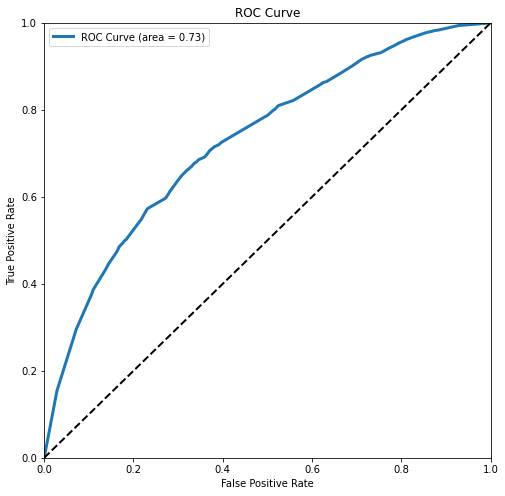

In [50]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], "k--", lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

## Scaling with Dask and Coiled

In the previous section, we trained a model with a subset of the full Higgs dataset. In this section, we will use the full dataset with 11 million samples! With this increased number of samples, the dataset may not fit comfortably into memory on a personal laptop. So we'll use Dask and Coiled to expand our compute resources to the cloud to enable us to work with this larger datset.

Let's create a Coiled cluster using the `examples/xgboost` software environment, which has Dask, XGBoost, Scikit-learn, and other relavant packages installed, and then connect a `dask.distributed.Client` to our cluster so we can begin to submit tasks to the cluster.

In [ ]:
import coiled

cluster = coiled.Cluster(
    n_workers=10,
    name="xgboost-example",
    software="xgboost-example",
)

In [91]:
import dask.distributed

client = dask.distributed.Client(cluster)
client

<Client: 'tls://10.0.9.70:8786' processes=10 threads=20, memory=37.75 GiB>

Dask's `read_csv` functions makes it easy to read in all the CSV files in the dataset:

In [ ]:
import dask.dataframe as dd

# Load the entire dataset using Dask
ddf = dd.read_csv("s3://coiled-data/higgs/higgs-*.csv", storage_options={"anon": True})

Dask's machine learning library, [Dask-ML](https://ml.dask.org/), mimics Scikit-learn's API, providing scalable versions of functions of `sklearn.datasets.make_classification` and `sklearn.model_selection.train_test_split` that are designed to work with Dask Arrays and DataFrames in larger-than-memory settings.

Let's use Dask-ML to generate a similar classification dataset as before, but now with 100 million samples.

In [93]:
from dask_ml.model_selection import train_test_split

X, y = ddf.iloc[:, 1:], ddf["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

Next we'll [persist our training and testing datasets](https://distributed.dask.org/en/latest/memory.html#persisting-collections) into distributed memory to avoid any unnecessary re-computations.

In [94]:
import dask

X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

To do distributed training of an XGBoost model, we'll use XGBoost with Dask (see the [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/tutorials/dask.html#distributed-xgboost-with-dask)).

In [95]:
dtrain = xgboost.dask.DaskDMatrix(client=client, data=X_train, label=y_train)
bst = xgboost.dask.train(client,  params, dtrain, num_boost_round=3)

Finally, we can again compute and plot the ROC curve for this model's predictions.

In [96]:
y_pred = xgboost.dask.predict(client, bst, X_test)
y_test, y_pred = dask.compute(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)

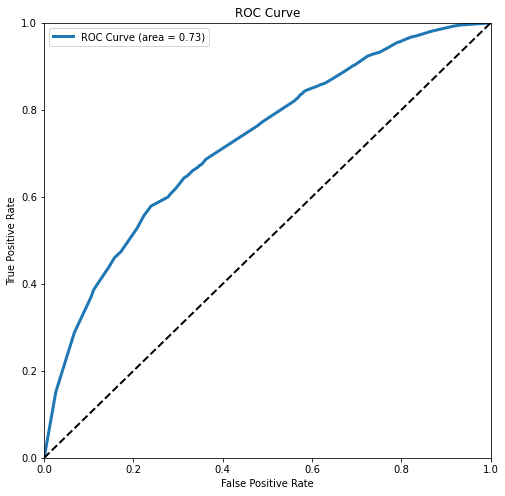

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], "k--", lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

Voilà! Congratulations on training a boosted decision tree in the cloud.

Once you're done, you can shutdown the cluster (it will shutdown automatically after 20 minutes of inactivity):

In [ ]:
cluster.close()
client.close()

## Next steps

For a more in-depth look at what you can do with XGBoost, Dask, and Coiled, check out [this Coiled blogpost](https://coiled.io/blog/dask-python-xgboost-example/).